<a href="https://colab.research.google.com/github/flaviorv/pb_ai_ml/blob/main/Copy_of_pb_tp4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

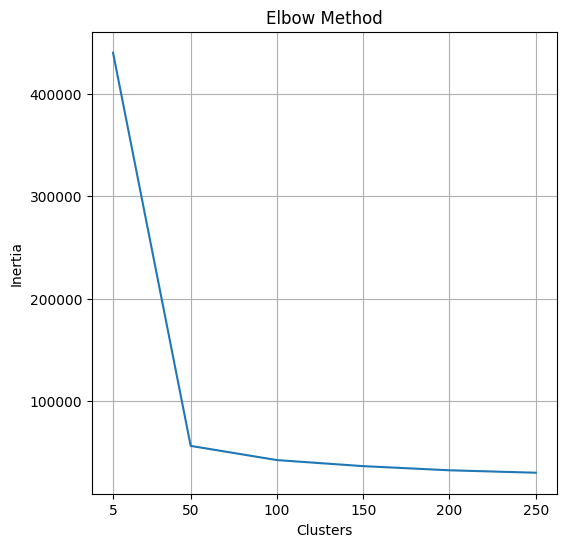

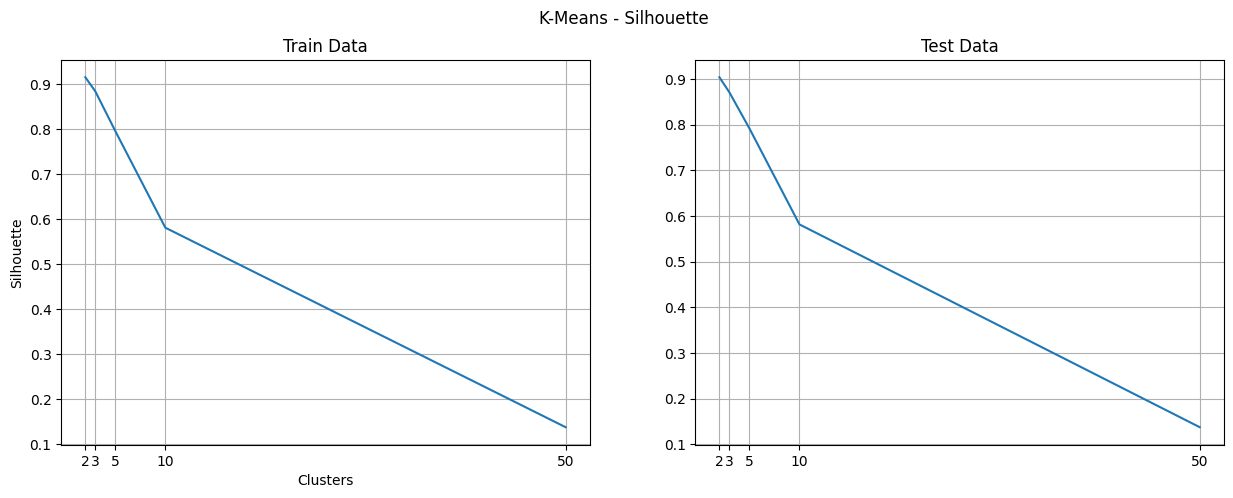

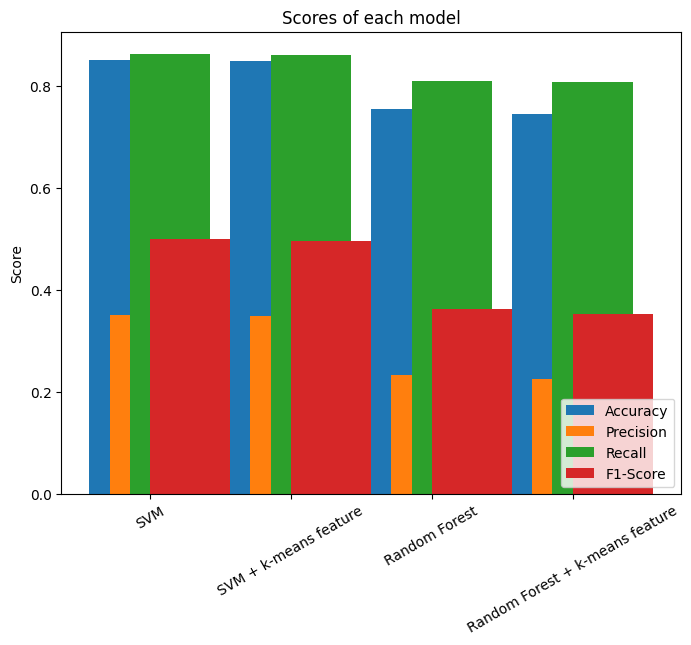

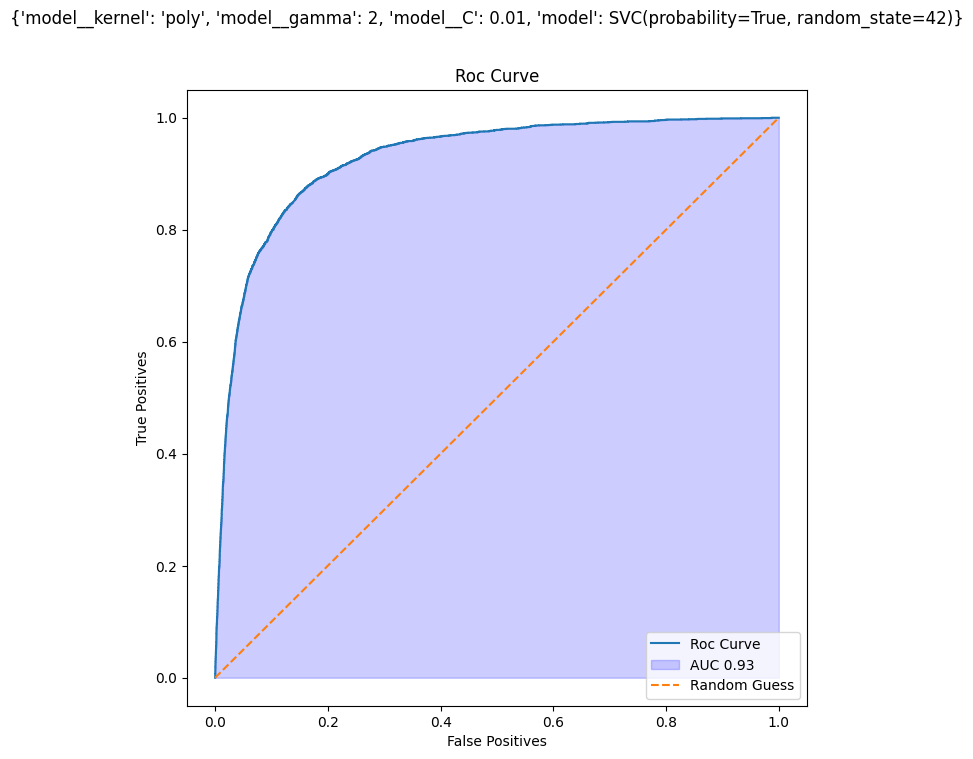

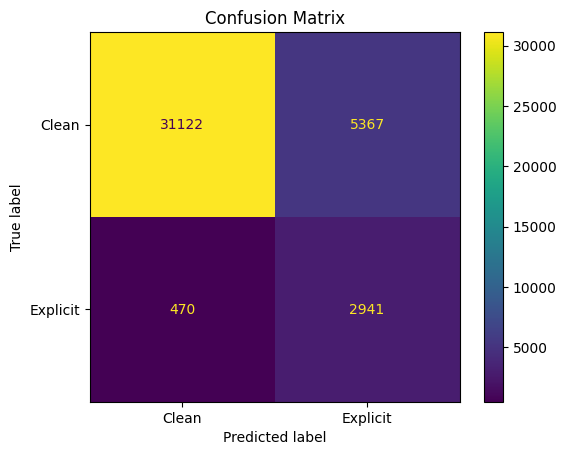

In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.feature_extraction import FeatureHasher
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt

# Carregando o dataset
df = pd.read_csv('https://raw.githubusercontent.com/flaviorv/pb_ai_ml/refs/heads/main/datasets/spotify.csv')

# Removendo features irrelevantes e amostras com dados incompletos
df.dropna(inplace=True)
df.drop(['Unnamed: 0', 'track_id'], axis=1, inplace=True)

# Separando feature e target
# O target em nosso caso é binário. Nele temos as classes música explícita e limpa
y = df.pop('explicit').astype(int)
x = df

# Dividindo entre treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35, stratify=y, random_state=42)

# Fazendo balanceamento dos dados, pois há muito mais amostras de músicas limpas do que explícitas.
# Foi utilizado o método de undersampling, pois o dataset já é bem grande e com muitas features categóricas,
# o que se tenha muitas dimensões e, consequentemente, muito tempo de processamento
rus = RandomUnderSampler(random_state=42)
x_train, y_train = rus.fit_resample(x_train, y_train)

# Separando features categóricas, categórica com muitas classes e contínuas
cat = ['key', 'time_signature', 'track_genre']
many_classes = ['artists', 'track_name', 'album_name']
cont = [
  'popularity', 'duration_ms', 'danceability',
  'energy', 'loudness', 'speechiness', 'acousticness',
  'instrumentalness', 'liveness','valence', 'tempo'
]

# Questão 1 - Clusterização K-Médias: Utilizaremos o algoritmo K-Médias para agrupar os dados do conjunto de treinamento.
# O número ótimo de clusters será determinado com base em métricas como o método do cotovelo e o índice de silhueta.

# Usando K-means para criar uma nova feature
# O K-means está sendo usado apenas nas features contínuas

# As features foram transformadas com o Robust Scaler. Antes dele, havia sido testado o MinMax Scaler, porém a clusterização
# não foi tão eficiente, não sei se pelo fato de ser sensível à outliers. O Min Max colca todas as features dentro do range
# entre 0 e 1, o que pode fazer com que dados discrepantes tenham uma influência maior dentro da escala. Já o Robust escala
# com base na mediana e no intervalo interquartil
kmeans_preprocessor = ColumnTransformer(
  transformers=[
    ('rs', RobustScaler(), cont),
  ]
)

# Hiperparâmetros
n_clusters = [5, 50, 100, 150, 200, 250]

# Escalando as features
sx_train = kmeans_preprocessor.fit_transform(x_train)
sx_test = kmeans_preprocessor.transform(x_test)

# Obtendo a inércia dos clusters
inertias = []
for i, k in enumerate(n_clusters):
  k_means = KMeans(n_clusters=k, random_state=42)
  train_clusters = k_means.fit_predict(sx_train)
  # Salvando os resultados
  inertias.append(k_means.inertia_)

# Plotando o método de cotovelo
# O método do cotovelo mostra, nesse caso, que 50 clusters é o indicativo de um bom número, pois, aumentando o número de clusters,
# a inércia não tem uma grande redução. Esse método ajuda a observar a compensação entre número de clusters e inércia. Uma inércia
# baixa indica que os pontos estão próximos do seu centróide, o que pode ser bom
plt.figure(figsize=(6,6))
plt.plot(n_clusters, inertias)
plt.xticks(n_clusters)
plt.ylabel('Inertia')
plt.xlabel('Clusters')
plt.grid(True)
plt.title('Elbow Method')
plt.show()

# Refinando a busca hiperparamétrica
n_clusters = [2, 3, 5, 10, 50]
silhouettes_train = []
silhouettes_test = []
metrics = {}
for k in n_clusters:
  k_means = KMeans(n_clusters=k, random_state=42)
  train_clusters = k_means.fit_predict(sx_train)
  test_clusters = k_means.predict(sx_test)
  # Salvando os resultados
  silhouettes_train.append(silhouette_score(sx_train, train_clusters))
  silhouettes_test.append(silhouette_score(sx_test, test_clusters))

# Plotando as métricas de silhouette
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
ax[0].plot(n_clusters, silhouettes_train)
ax[0].set_xticks(n_clusters)
ax[0].set_title('Train Data')
ax[1].plot(n_clusters, silhouettes_test)
ax[1].set_xticks(n_clusters)
ax[1].set_title('Test Data')
ax[0].set_ylabel('Silhouette')
ax[0].set_xlabel('Clusters')
ax[0].grid(True)
ax[1].grid(True)
plt.suptitle('K-Means - Silhouette')
plt.show()

# Questão 2 - Criação de Features: Para cada instância nos conjuntos de treinamento e teste, será gerada
# uma nova feature indicando a distância da instância ao centro do cluster mais próximo. Este processo visa
# incorporar a estrutura de agrupamento dos dados como uma informação adicional para o modelo de aprendizado supervisionado.

# Apesar do método do cotovelo ter apontado 50 clusters, o Silhouette mostra que os dados estão melhor separados a medida
# que número de clusters diminui. Para haver uma compensação, foi escolhido 10 como número de clusters para se criar uma nova feature.
# Dessa forma, a nova feature terá 10 classes.

# Usando o melhor hiperparâmetro para criar a feature
k_means = KMeans(n_clusters=10)
c_train = k_means.fit_predict(sx_train)
c_test = k_means.predict(sx_test)

# Convertendo de ndarray para dataframe
labels_train = pd.DataFrame(c_train, columns=['cluster'], index=x_train.index)
labels_test = pd.DataFrame(c_test, columns=['cluster'], index=x_test.index)

# Craindo novo conjunto de dados com a nova feature
cx_train = pd.concat([x_train, labels_train], axis=1)
cx_test = pd.concat((x_test, labels_test), axis=1)

# Usando o hashing trick para nas features com muitas classes para que a dimensionalidade diminua
class HashingWrapper(BaseEstimator, TransformerMixin):
  def __init__(self, n_features=2000, dtype=float):
    self.n_features = n_features
    self.dtype = dtype
    self.hasher = FeatureHasher(n_features=self.n_features, input_type='dict', dtype=self.dtype)

  def fit(self, x, y=None):
    return self

  def transform(self, x):
    x = x.to_dict(orient="records")
    return self.hasher.transform(x)

# Escalando as features contínuas e codificando as features categóricas
preprocessor = ColumnTransformer(transformers=[
  ('min_max', MinMaxScaler(), cont),
  ('one_hot', OneHotEncoder(handle_unknown='ignore'), cat),
  ('hashing_trick', HashingWrapper(), many_classes)
], remainder='passthrough')

# Automatizando os passos
pipeline = Pipeline(steps=[
  ('scalers', preprocessor),
  ('model', DummyClassifier())
])

# Questão 3 - Modelo de ML: Serão treinados utilizando tanto o conjunto de features original quanto o conjunto de features
# expandido com as distâncias dos clusters. Use:
# a - Modelos SVM com diferentes configurações de kernel (linear, polinomial, RBF) e parâmetros de regularização para otimizar o desempenho.
# b - Modelos Random Forest com diferentes parâmetros para otimizar o desempenho.

# Support Vector Machine tem a opção de separação linear ou a criação de kernels para amento da dimensão, facilitando a separação de classes
# que anteriormente não eram separáveis. Esses valores devem ser testados no grid search para um melhor resultado

# Hiperparâmetros do SVM
svm_params = [
  {
    'model': [SVC(random_state=42, probability=True)],
    'model__kernel': ['linear'],
    'model__C': [0.01, 0.1, 1],
  },
  {
    'model': [SVC(random_state=42, probability=True)],
    'model__kernel': ['rbf', 'poly'],
    'model__C': [0.01, 0.1, 1],
    'model__gamma': [0.01, 1, 2]
  },
]

# Random forest tem maior capacidade de generalização do que as árvores de decisão. Esse modelo é um esemble das árvores. Também precisamos
# podar as árvores dentro do Random Forest para que não aprendam demais e causem overfitting.

# Hiperparâmetros do Random Forest
rf_params = [
  {
    'model': [RandomForestClassifier(random_state=42)],
    'model__n_estimators': [30, 50, 100, 300],
    'model__max_depth': [3, 5, 10, 15, 30, 40],
    'model__min_samples_split': [2, 4, 8, 12],
    'model__min_samples_leaf': [1, 5, 10],
    'model__max_leaf_nodes': [10, 20, 30, 50, None],
    'model__criterion': ['gini', 'entropy', 'log_loss']
  }
]

# Número máximo de iterações do grid search
n_iter = 10
# Número de folds da validação cruzada
cv = 2

# Grid do SVM sem a nova feature
svm_grid = RandomizedSearchCV(pipeline, svm_params, n_iter=n_iter, cv=cv, n_jobs=-1, random_state=42)
svm_grid.fit(x_train, y_train)
svm_pred = svm_grid.predict(x_test)

# Grid do Random Forest sem a nova feature
rf_grid = RandomizedSearchCV(pipeline, rf_params, n_iter=n_iter, cv=cv, n_jobs=-1, random_state=42)
rf_grid.fit(x_train, y_train)
rf_pred = rf_grid.predict(x_test)

# Adicionando a nova feature
cat2 = cat.copy()
cat2.append('cluster')

# Preprocessamento com a nova feature
preprocessor2 = ColumnTransformer(
  transformers=[
    ('one_hot', OneHotEncoder(handle_unknown='ignore'), cat2),
    ('min_max', MinMaxScaler(), cont),
    ('hashing_trick', HashingWrapper(), many_classes)
  ], remainder='passthrough'
)

# Automatizando as etapas
pipeline2 = Pipeline(steps=[
  ('scalers', preprocessor2),
  ('model', DummyClassifier())
])

# Grid do SVM com a nova feature
svm_grid2 = RandomizedSearchCV(pipeline2, svm_params, n_iter=n_iter, cv=cv, n_jobs=-1, random_state=42)
svm_grid2.fit(cx_train, y_train)
svm_pred2 = svm_grid2.predict(cx_test)

# Grid do Random Forest com a nova feature
rf_grid2 = RandomizedSearchCV(pipeline2, rf_params, n_iter=n_iter, cv=cv, n_jobs=-1, random_state=42)
rf_grid2.fit(cx_train, y_train)
rf_pred2 = rf_grid2.predict(cx_test)

# Questão 4 - Avaliação de Modelos: O desempenho dos modelos será avaliado com base em métricas de classificação padrão,
# como precisão, recall, F1-score e AUC-ROC, utilizando os conjuntos de teste.

# Plotando os resultados de cada modelo
groups = ['SVM', 'SVM + k-means feature', 'Random Forest', 'Random Forest + k-means feature']
preds = [svm_pred, svm_pred2, rf_pred, rf_pred2]

accuracy = []
precision = []
recall = []
f1 = []

for pred in preds:
  results = classification_report(y_test, pred, output_dict=True)
  accuracy.append(results['accuracy'])
  precision.append(results['1']['precision'])
  recall.append(results['1']['recall'])
  f1.append(results['1']['f1-score'])

n_groups = len(groups)
n_bars = 4
bar_width = 0.2
group_spacing = 0.6

x = np.arange((n_groups)) * (n_bars * bar_width + group_spacing)

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x, accuracy, label='Accuracy')
ax.bar(x + bar_width, precision, label='Precision')
ax.bar(x + 2*bar_width, recall, label='Recall')
ax.bar(x + 3*bar_width, f1, label='F1-Score')
plt.legend(loc='lower right')
ax.set_xticks(x + bar_width)
ax.set_xticklabels(groups, rotation=30)
ax.set_ylabel('Score')
ax.set_title('Scores of each model')
plt.show()

# Questão 5 - Análise Comparativa: Será realizada uma análise comparativa para avaliar o impacto da adição das features de clusterização
# no desempenho dos modelos de ML. Além disso, será discutida a influência do número de clusters e das configurações do ML nas métricas de
# desempenho. Use gráficos para ilustrar seus argumentos.

# Apesar de os gráficos do k-means sugerirem que o os clusters tiveram uma boa separação, a nova feature não influenciou muito no modelo.
# O que faz do modelo sem a nova feature o melhor, pois terá menos dados, menos uma dimensão e menos um custo computacional desnecessário.
# Pode-se ver no gráfico 'Scores of each model', que os resultados foram muito próximos com relação a usar ou não a nova feature

# Acurácia e recall, tiveram score acima de 80% com o SVM e acima de 70% com o Random Forest. Já a métrica de precisão, não teve bons resultados
# isso fez com que o f1-score fosse penalizado, pois ele é a média harmônica entre precisão e recall

# Obtendo as probabilidades da classe Explícita
y_score = svm_grid.predict_proba(x_test)[:, 1]

# Obtendo Falsos Positivos e Verdadeiros Positivos
fpr, tpr, thresholds = roc_curve(y_test, y_score)
# Calculando a área sob a curva ROC
_auc = auc(fpr, tpr)

# Plotando a curva ROC
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label='Roc Curve')
plt.fill_between(fpr, tpr, alpha=0.2, color='blue', label=f'AUC {_auc:.2f}')
plt.xlabel('False Positives')
plt.ylabel('True Positives')
plt.title('Roc Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.suptitle(svm_grid.best_params_)
plt.legend(loc='lower right')
plt.show()

# O modelo que obteve melhores resultados foi o SVM polinomial. Sua curva
# ROC está muito acima do random guess line. A área sob a curva de 0.92, mostra
# que o modelo explica bem os dados

# Obtendo o melhor threshold
J = tpr - fpr
idx = np.argmax(J)
best_threshold = thresholds[idx]
_y_pred = (y_score > best_threshold).astype(int)

# Plotando a matriz de confusão
cm = confusion_matrix(y_test, _y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Clean', 'Explicit'])
cm_display.plot()
plt.title('Confusion Matrix')
plt.show()

# A matriz de confusão mostra que o modelo realmente previu muitas músicas
# Clean como Explicit, o que gera a baixa precisão, porém comparando os falsos
# negativos com verdadeiros positivos, a taxa de acerto foi boa, o que gerou o
# alto valor de recall. Ter muito mais acertos do que erros contando todas as
# predições explica o número alto da acurácia.